<a href="https://colab.research.google.com/github/tejal-p05/upskillcampus/blob/main/Forecasting_of_Smart_city_traffic_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import datetime

In [4]:
df_train=pd.read_csv("train_aWnotuB.csv",parse_dates=['DateTime'])
df_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
df_test=pd.read_csv("datasets_8494_11879_test_BdBKkAj.csv",parse_dates=['DateTime'])
df_test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [6]:
df_train.shape

(48120, 4)

In [7]:
df_test.shape

(11808, 3)

In [8]:
df_train.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [9]:
df_tmp = df_train.set_index(['Junction','DateTime'])

In [10]:
level_values = df_tmp.index.get_level_values

In [11]:
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1         2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4         2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: int64

In [12]:
del df_tmp
del time_targets

**Lag Features**

In [13]:
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [14]:
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0 KB


In [16]:
value=round(train[4].max())/1.0
value

36.0

In [17]:
train = train.fillna(value)

In [18]:
train.isnull().sum()

Junction
1    0
2    0
3    0
4    0
dtype: int64

**Generate lag features**

In [19]:
def gen_lag_features(df, n_in=1,n_out=1,dropnan=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-11-01 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-11-01 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-11-01 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-11-01 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143,0.662252,0.702128,0.178771,0.285714
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714,0.602649,0.723404,0.167598,0.828571
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571,0.562914,0.638298,0.150838,0.428571


**Split train and valid (and normalize for real)**

In [22]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]

In [23]:
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [24]:
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]

In [25]:
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


**Reshape the Data**

In [26]:
X_train.shape

(12407, 4)

In [27]:
y_train.shape

(12407, 4)

In [28]:
X_train = np.expand_dims(X_train.values,axis=2)

In [29]:
X_train.shape

(12407, 4, 1)

In [30]:
y_train= y_train.values

In [31]:
y_train.shape

(12407, 4)

**Modeling**

In [32]:
!pip install tensorflow

In [33]:
# Install TensorFlow
!pip install tensorflow

# Import required libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.initializers import he_normal
import keras.backend as K

# Define custom loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Sample model definition for reference
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [35]:
# Initialising the RNN
regressor= Sequential()

#Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

In [36]:
# Fitting the RNN to the Training set
regressor.fit(X_train,y_train,batch_size=120,epochs=100,verbose=1)

Epoch 1/100
104/104 [==============================] - 3s 8ms/step - loss: 0.1791
Epoch 2/100
104/104 [==============================] - 1s 6ms/step - loss: 0.0445
Epoch 3/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0375
Epoch 4/100
104/104 [==============================] - 1s 12ms/step - loss: 0.0354
Epoch 5/100
104/104 [==============================] - 1s 14ms/step - loss: 0.0344
Epoch 6/100
104/104 [==============================] - 1s 11ms/step - loss: 0.0336
Epoch 7/100
104/104 [==============================] - 1s 12ms/step - loss: 0.0330
Epoch 8/100
104/104 [==============================] - 2s 16ms/step - loss: 0.0327
Epoch 9/100
104/104 [==============================] - 2s 22ms/step - loss: 0.0328
Epoch 10/100
104/104 [==============================] - 1s 12ms/step - loss: 0.0326
Epoch 11/100
104/104 [==============================] - 1s 11ms/step - loss: 0.0323
Epoch 12/100
104/104 [==============================] - 1s 11ms/step - loss: 0.0324
Epoc

**Validating**

In [37]:
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.142857
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.114286
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.085714
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.085714
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571


In [38]:
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid)

69/69 [==============================] - 1s 4ms/step


In [39]:
# we rescale y in the integer count range
# to do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[67.26414782, 24.91769987, 27.30440325,  6.92233129],
       [61.62647155, 23.15101203, 20.79001193,  6.32347329],
       [53.34669381, 23.02621725, 13.04271225,  4.960522  ],
       ...,
       [92.08563793, 28.30336797, 28.49106984, 27.83014929],
       [86.26319897, 27.94635522, 26.1273603 , 11.80586419],
       [80.87249547, 25.28332698, 24.34525457, 18.1962662 ]])

In [40]:
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


**Visualizing the data**

In [41]:
import matplotlib.pyplot as plt

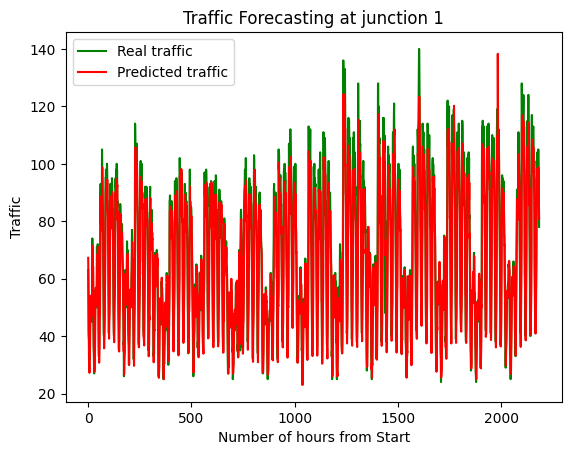

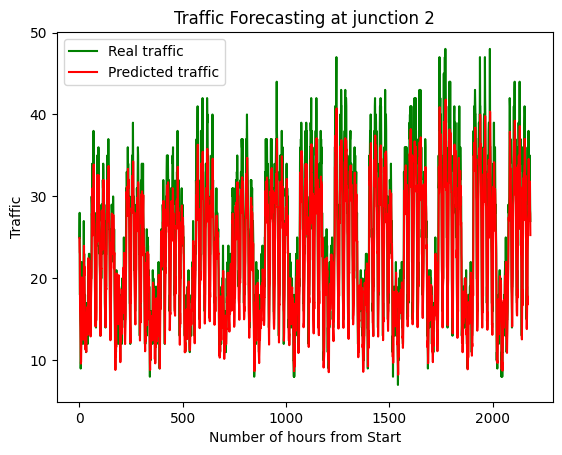

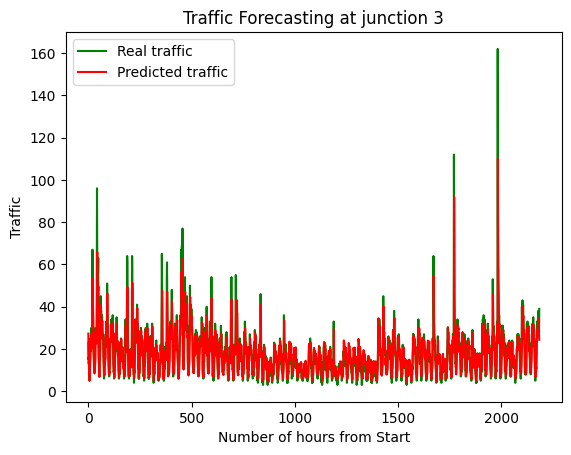

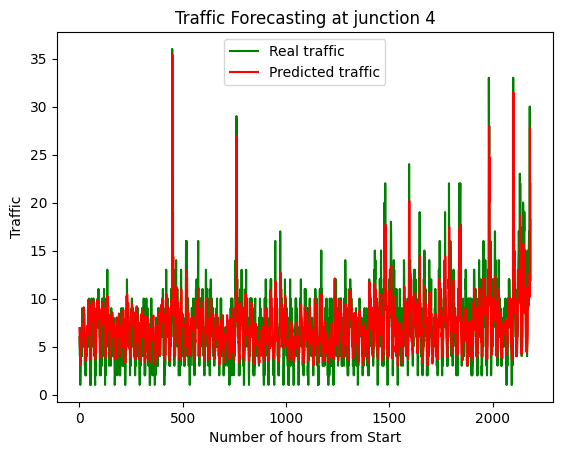

In [42]:
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic')
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [44]:
rmse(y_truth,y_pred)

5.930063464062473

In [45]:
trdf = pd.read_csv('train_aWnotuB.csv')
trainMat= trdf.values
tedf = pd.read_csv('datasets_8494_11879_test_BdBKkAj.csv')
testMat=tedf.values
train=[]
target=[]
print(trainMat)
for i in trainMat:
    s=i[3]
    year=s/(10**7)
    s=s%(10**7)
    month=s/(10**5)
    s=s%(10**5)
    date=s/(10**3)
    s=s%(10**3)
    time=s/(10)
    s=s%(10)
    junction =s
    train.append([year,month,date,time,junction])
    target.append(i[2])
X= np.array(train)
y=np.array(target)

[['2015-11-01 00:00:00' 1 15 20151101001]
 ['2015-11-01 01:00:00' 1 13 20151101011]
 ['2015-11-01 02:00:00' 1 10 20151101021]
 ...
 ['2017-06-30 21:00:00' 4 16 20170630214]
 ['2017-06-30 22:00:00' 4 22 20170630224]
 ['2017-06-30 23:00:00' 4 12 20170630234]]


In [46]:
jun1=[]
jun2=[]
jun3=[]
jun4=[]
jun5=[]
jun=[jun1,jun2,jun3,jun4,jun5]
for i in range(0,len(train),24):
    ct=0
    for j in range(24):
        ct+=target[i+j]
    jun[train[i][4]-1].append(ct)
jun[3]=[0]*(len(jun[0])-len(jun[3]))+jun[3]
print(len(jun[0]),len(jun[1]),len(jun[2]),len(jun[3]))

k=7
week=[[] for i in range(k)]
for i in range(len(jun[1])):
    week[i%k].append(jun[1][i])
for i in range(k):
    print(np.mean(week[i]))
hour=[[] for i in range(24)]
for i in range(len(jun[0])*24+len(jun[1])*24, len(jun[0])*24+len(jun[1])*24+len(jun[2])*24):
    hour[i%24].append(target[i])
for i in range(24):
    print(np.mean(hour[i]))

temp=[-i for i in jun[3]]
jun[4]=np.add(jun[2],temp)

608 608 608 608
243.45977011494253
365.4942528735632
397.367816091954
394.0
384.632183908046
358.62068965517244
249.90697674418604
14.174342105263158
9.856907894736842
8.055921052631579
6.776315789473684
5.978618421052632
5.685855263157895
6.2368421052631575
7.550986842105263
9.057565789473685
11.429276315789474
15.004934210526315
17.1875
17.707236842105264
16.049342105263158
17.57236842105263
17.37171052631579
16.88157894736842
16.901315789473685
17.929276315789473
19.129934210526315
20.200657894736842
18.72203947368421
17.394736842105264
15.800986842105264


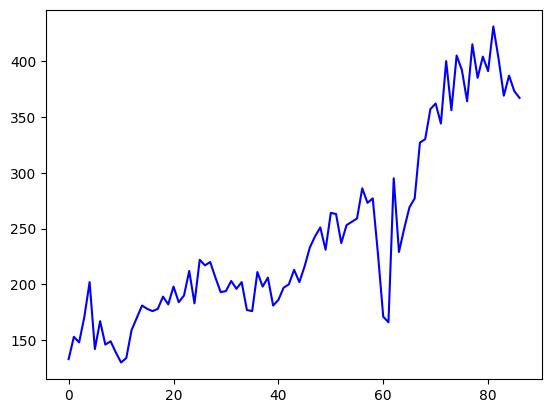

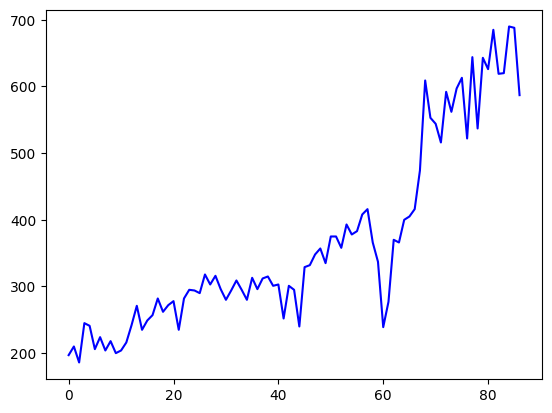

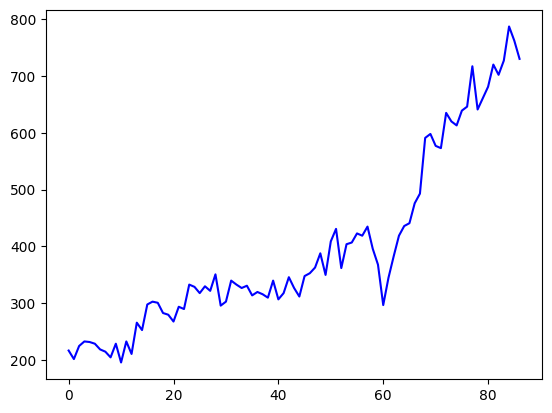

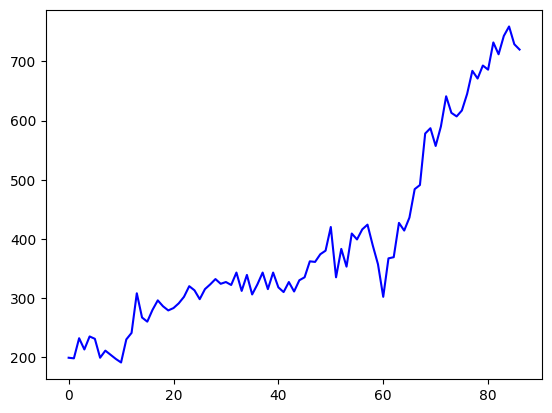

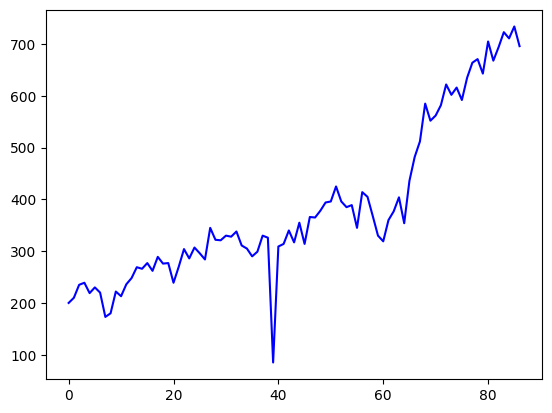

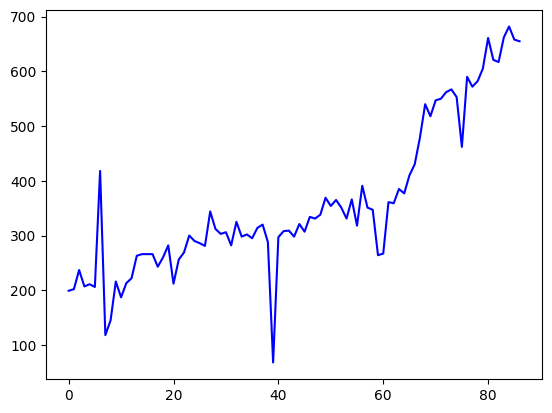

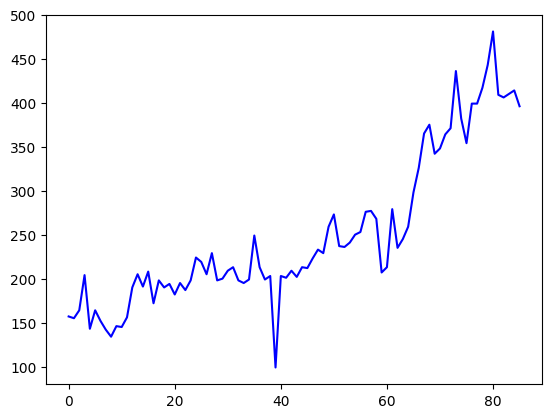

In [47]:
import matplotlib.pyplot as plt
for i in range(len(week)):
    plt.plot(week[i],'blue')
    plt.show()

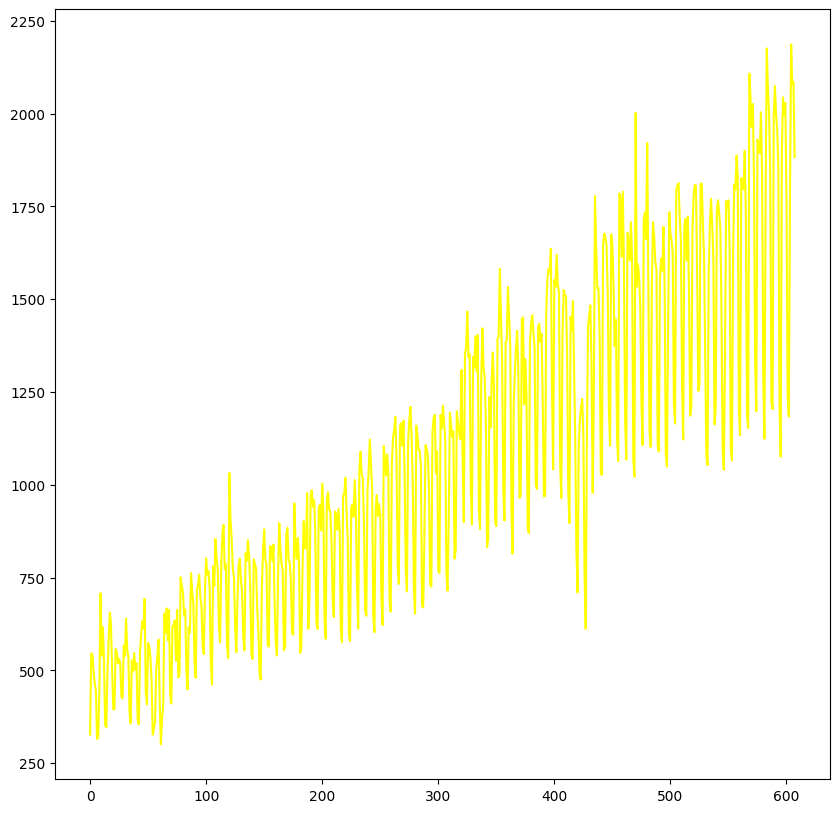

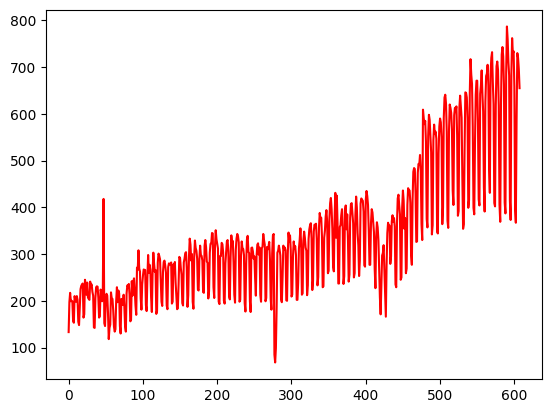

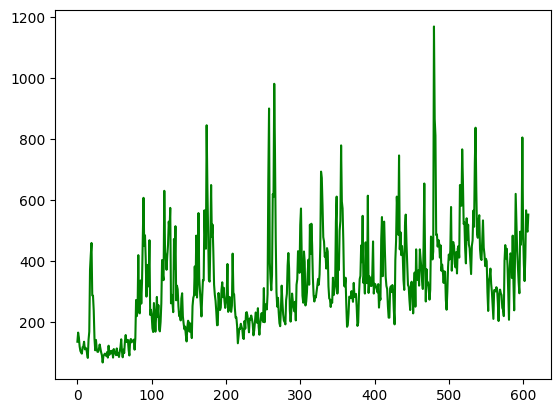

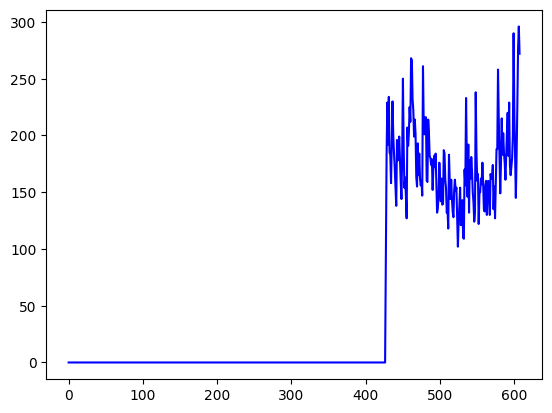

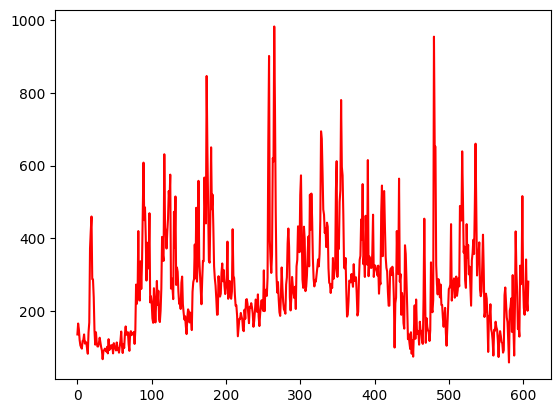

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(jun[0],'yellow')
plt.show()
plt.plot(jun[1],'red')
plt.show()
plt.plot(jun[2],'green')
plt.show()
plt.plot(jun[3],'blue')
plt.show()
plt.plot(jun[4],'red')
plt.show()

**Random Forest Classifier**

In [49]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=7)
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(criterion='entropy',min_samples_split=100,min_samples_leaf=10,max_depth=12)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [50]:
clf.fit(X,y)
pred = clf.predict(X)
val1=(accuracy_score(y,pred)*100)
print("Accuracy Score for Random Forest :",val1*5)

Accuracy Score for Random Forest : 102.87822111388196


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse1(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [52]:
rmse1(y,pred)

7.788915648698709

**Decision Tree Classifie**r

In [53]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X,y)
pred2 = DT.predict(X)
val2= (accuracy_score(y,pred2)*100)
print("Accuracy score for Decision tree classifer : ",val2*5)

Accuracy score for Decision tree classifer :  500.0


**Support Vector Machine**

In [54]:
from sklearn.svm import SVC
SVM = SVC(kernel='linear')
SVM.fit(X,y)
predictions = SVM.predict(X)
val3= (accuracy_score(y,pred)*100)
print("Accuracy score for SVM : ",val3*5)

Accuracy score for SVM :  102.87822111388196


**XGBoosting**

In [56]:
!pip install xgboost

In [57]:
from xgboost import XGBClassifier
XGboost = XGBClassifier(use_label_encoder=False,objective="multi:softmax",eval_metric="merror",n_estimators=20,max_depth=10,random_state=42)
XGboost.fit(X,y)
pred4=XGboost.predict(X)
val4=(accuracy_score(y,pred4)*100)
print("Accuracy score for XGBoosting : ",val4*5)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140], got [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 132 133 134 135 136 140 141 143 156 162 173 180]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Bring some raw data
frequencies =[val1,val2,val3]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['Rf','DT','SVM']

#plot the figure
plt.figure(figsize=(12,8))
ax= freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & Dl')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)

def add_value_labels(ax,spacing=5):
    #for each bar: Place a label
    for rect in ax.patches:
        y_value= rect.get_height()
        x_value= rect.get_x() + rect.get_width()/2
        space=spacing
        va='bottom'
        if y_value<0:
            space*=-1
            va='top'
        label ="{:.1f}".format(y_value)

    #create annotation
        ax.annotate(label,
                    (x_value,y_value),
                   xytext=(0,space),
                   textcoords="offset points",
                   ha='center',
                   va=va)
# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()